# 1083 Albumin Initial ML

### By: Ian Weimer

In [2]:
import imblearn
print("Imbalanced-Learn", imblearn.__version__)

Imbalanced-Learn 0.9.1


In [3]:
#print("Imbalanced-Learn", imbalanced-learn.__version__)

## Imports

In [4]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from scipy import stats
import math
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from statsmodels.regression.linear_model import OLS
from sklearn.model_selection import cross_val_score
from statsmodels.tools.tools import add_constant
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_curve, auc, confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import auc, plot_precision_recall_curve
import warnings
from sklearn.compose import make_column_transformer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import balanced_accuracy_score
import graphviz
import pydotplus
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE, SMOTEN, SMOTENC
pd.set_option('display.max_columns', None)

## Load Albumin Data From Pre-processing and Exploratory Analysis

In [5]:
df = pd.read_csv('/Users/ianweimer/desktop/jupyternotebooks/1083-albumin-data-exploration/ML/tables/albumin_cleaned_11.csv')

In [6]:
# drop insignificant vars

#df.drop(columns = ['bed_size', 'Cirrhosis', 'tenant'], inplace=True)

In [7]:
df.head()

ICU  mass_transfusion  total_transfusions  anemia_status  CCI  \
0    1                 0                   1            2.0    6   
1    1                 1                   0            0.0    4   
2    0                 0                   0            1.0    3   
3    0                 0                   0            3.0    2   
4    1                 0                   0            0.0    4   

   bl_albumin_value  albumin_24hrs  qSOFA  Cirrhosis  beta_blocker  \
0               2.9            0.0      1          0             1   
1               3.1            0.0      0          1             0   
2               2.2            0.0      0          1             0   
3               1.5            0.0      0          1             0   
4               3.5            1.0      1          0             1   

   hemorrhagic  SAPS  30_day_mortality  30_day_readmission  LOS_days  
0            0    34                 0                   0         2  
1            0    18                 0                   1         2  
2            0    29                 0                   0         2  
3            0    43                 0                   0         1  
4            0    34                 0                   1         2

In [8]:
df.shape

(61109, 15)

In [9]:
df.drop(columns=['30_day_readmission', 'LOS_days'], inplace=True)

In [10]:
#df.drop(columns=['bl_albumin_value'], inplace=True)

In [11]:
# remove ICU
# note: should remove from this analysis in earlier file
#df.drop(columns=['ICU'], inplace=True)

In [12]:
#df.drop(columns=['CCI'], inplace=True)

In [13]:
#df.drop(columns=['qSOFA'], inplace=True)

In [14]:
#df.drop(columns=['albumin'], inplace=True)

In [15]:
df.describe()

ICU  mass_transfusion  total_transfusions  anemia_status  \
count  61109.000000      61109.000000        61109.000000   61109.000000   
mean       0.210444          0.030307            0.581764       1.701795   
std        0.407627          0.171431            0.968769       1.116495   
min        0.000000          0.000000            0.000000       0.000000   
25%        0.000000          0.000000            0.000000       1.000000   
50%        0.000000          0.000000            0.000000       2.000000   
75%        0.000000          0.000000            1.000000       3.000000   
max        1.000000          1.000000            5.000000       3.000000   

                CCI  bl_albumin_value  albumin_24hrs         qSOFA  \
count  61109.000000      61109.000000   61109.000000  61109.000000   
mean       3.979414          3.022666       0.084996      0.504787   
std        2.733080          0.699047       0.278878      0.697482   
min        0.000000          0.002700       0.000000      0.000000   
25%        2.000000          2.600000       0.000000      0.000000   
50%        4.000000          3.000000       0.000000      0.000000   
75%        6.000000          3.500000       0.000000      1.000000   
max       19.000000          6.300000       1.000000      3.000000   

          Cirrhosis  beta_blocker   hemorrhagic          SAPS  \
count  61109.000000  61109.000000  61109.000000  61109.000000   
mean       0.272857      0.336481      0.073950     26.358818   
std        0.445431      0.472509      0.261691     11.067891   
min        0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000     18.000000   
50%        0.000000      0.000000      0.000000     25.000000   
75%        1.000000      1.000000      0.000000     33.000000   
max        1.000000      1.000000      1.000000     64.000000   

       30_day_mortality  
count      61109.000000  
mean           0.085699  
std            0.279922  
min            0.000000  
25%            0.000000  
50%            0.000000  
75%            0.000000  
max            1.000000

In [16]:
#df = df[['CCI', 'unknown_albumin_type', 'albumin_24hrs', '25_percent_albumin', 'LOS_days']]

## Modeling

In [17]:
# establish target feature, LOS_days, as y feature
y = df['30_day_mortality']
# drop target feature from features dataframe
X = df.drop(columns = ['30_day_mortality'], axis = 1)
# save dataframe column titles to list for reassigning after min max scale 
cols = X.columns

In [18]:
cols

Index(['ICU', 'mass_transfusion', 'total_transfusions', 'anemia_status', 'CCI',
       'bl_albumin_value', 'albumin_24hrs', 'qSOFA', 'Cirrhosis',
       'beta_blocker', 'hemorrhagic', 'SAPS'],
      dtype='object')

## Standardize Data

In [19]:
#cols = X.columns

#instantiate min-max scaling object
#mm = MinMaxScaler()
# fit and transform feature dataframe
#X = pd.DataFrame(mm.fit_transform(X))
# reassign column names so new dataframe has corresponding names
#X.columns = cols

In [20]:
X.head()

ICU  mass_transfusion  total_transfusions  anemia_status  CCI  \
0    1                 0                   1            2.0    6   
1    1                 1                   0            0.0    4   
2    0                 0                   0            1.0    3   
3    0                 0                   0            3.0    2   
4    1                 0                   0            0.0    4   

   bl_albumin_value  albumin_24hrs  qSOFA  Cirrhosis  beta_blocker  \
0               2.9            0.0      1          0             1   
1               3.1            0.0      0          1             0   
2               2.2            0.0      0          1             0   
3               1.5            0.0      0          1             0   
4               3.5            1.0      1          0             1   

   hemorrhagic  SAPS  
0            0    34  
1            0    18  
2            0    29  
3            0    43  
4            0    34

In [21]:
X.shape

(61109, 12)

## Train Test Split

In [22]:
#sm = SMOTENC(random_state=42, categorical_features = [0, 1, 2, 3, 4, 5, \
#                                                     6, 7, 8, 9, 10])
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
#X_train, y_train = sm.fit_resample(X_train, y_train)

In [23]:
sm = SMOTEN(random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [24]:
y_train.value_counts()

0    44692
1    44692
Name: 30_day_mortality, dtype: int64

In [25]:
# train test split from target feature series and the predicting feature dataframe (set test size to 20% of data)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 33)

## Multinomial Logistic Regression

In [26]:
# instantiate a Logistic Regression model without an intercept, 'liblinear' solver method
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs')
# fit the model to X and y training sets
logreg.fit(X_train, y_train)

/Users/ianweimer/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(multi_class='multinomial')

Feature: ICU Score: 0.42456
Feature: mass_transfusion Score: 0.50585
Feature: total_transfusions Score: -0.33999
Feature: anemia_status Score: -0.23108
Feature: CCI Score: 0.08218
Feature: bl_albumin_value Score: -0.54410
Feature: albumin_24hrs Score: 0.20493
Feature: qSOFA Score: 0.14839
Feature: Cirrhosis Score: -0.04000
Feature: beta_blocker Score: -0.52723
Feature: hemorrhagic Score: 0.19330
Feature: SAPS Score: 0.00912


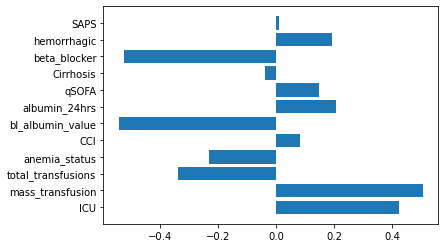

In [27]:
# general quick feature importance
# get coefficients for importance
# coefficients represent the log odds that an observation is in the
# target class, given the values of its X variables

importance = logreg.coef_[0]
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()

                    Importance
mass_transfusion      1.658391
ICU                   1.528919
albumin_24hrs         1.227438
hemorrhagic           1.213250
qSOFA                 1.159963
CCI                   1.085654
SAPS                  1.009166
Cirrhosis             0.960786
anemia_status         0.793676
total_transfusions    0.711779
beta_blocker          0.590237
bl_albumin_value      0.580364


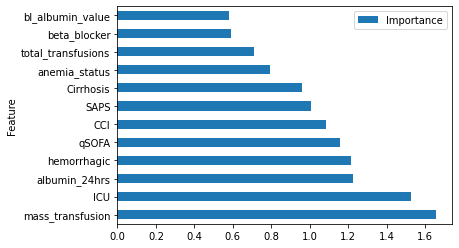

In [28]:
# convert log odds into regular odds with exponentiation
# np.exp()
# and list values, visualize in bar plot

odds = np.exp(logreg.coef_[0])
feature_importance = \
            pd.DataFrame(odds, 
             X.columns, 
             columns=['Importance'])\
            .sort_values(by='Importance', ascending=False)
        
ax = feature_importance.plot.barh(xlabel='Feature', ylabel='Importance')
print(feature_importance)
plt.show()

In [29]:
# Generate model prediction data for train and test sets
y_hat_train = logreg.predict(X_train)
y_hat_test = logreg.predict(X_test)

In [30]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[33735 10957]
 [10761 33931]]


In [31]:
# model metrics for training set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

           0       0.76      0.75      0.76     44692
           1       0.76      0.76      0.76     44692

    accuracy                           0.76     89384
   macro avg       0.76      0.76      0.76     89384
weighted avg       0.76      0.76      0.76     89384



In [32]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[8388 2792]
 [ 434  608]]


In [33]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.95      0.75      0.84     11180
           1       0.18      0.58      0.27      1042

    accuracy                           0.74     12222
   macro avg       0.56      0.67      0.56     12222
weighted avg       0.88      0.74      0.79     12222



## 1: Decision Tree (Max Depth=3)

In [34]:
# instantiate a decision tree model
# max_depth limits depth of tree, helps prevent overfitting training data
dt = tree.DecisionTreeClassifier(max_depth=3)
# fit the model to X and y training sets
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

Feature: ICU Score: 0.04388
Feature: mass_transfusion Score: 0.00000
Feature: total_transfusions Score: 0.30441
Feature: anemia_status Score: 0.00000
Feature: CCI Score: 0.00000
Feature: bl_albumin_value Score: 0.49076
Feature: albumin_24hrs Score: 0.00000
Feature: qSOFA Score: 0.00000
Feature: Cirrhosis Score: 0.00000
Feature: beta_blocker Score: 0.15650
Feature: hemorrhagic Score: 0.00000
Feature: SAPS Score: 0.00446


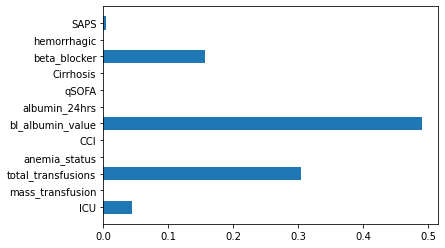

In [35]:
# get importance from decision tree model
importance = dt.feature_importances_
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()

In [36]:
# generate model prediction data for train and test sets
y_hat_train = dt.predict(X_train)
y_hat_test = dt.predict(X_test)

In [37]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[32189 12503]
 [13379 31313]]


In [38]:
# model metrics for train set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

           0       0.71      0.72      0.71     44692
           1       0.71      0.70      0.71     44692

    accuracy                           0.71     89384
   macro avg       0.71      0.71      0.71     89384
weighted avg       0.71      0.71      0.71     89384



In [39]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[8072 3108]
 [ 560  482]]


In [40]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.94      0.72      0.81     11180
           1       0.13      0.46      0.21      1042

    accuracy                           0.70     12222
   macro avg       0.53      0.59      0.51     12222
weighted avg       0.87      0.70      0.76     12222



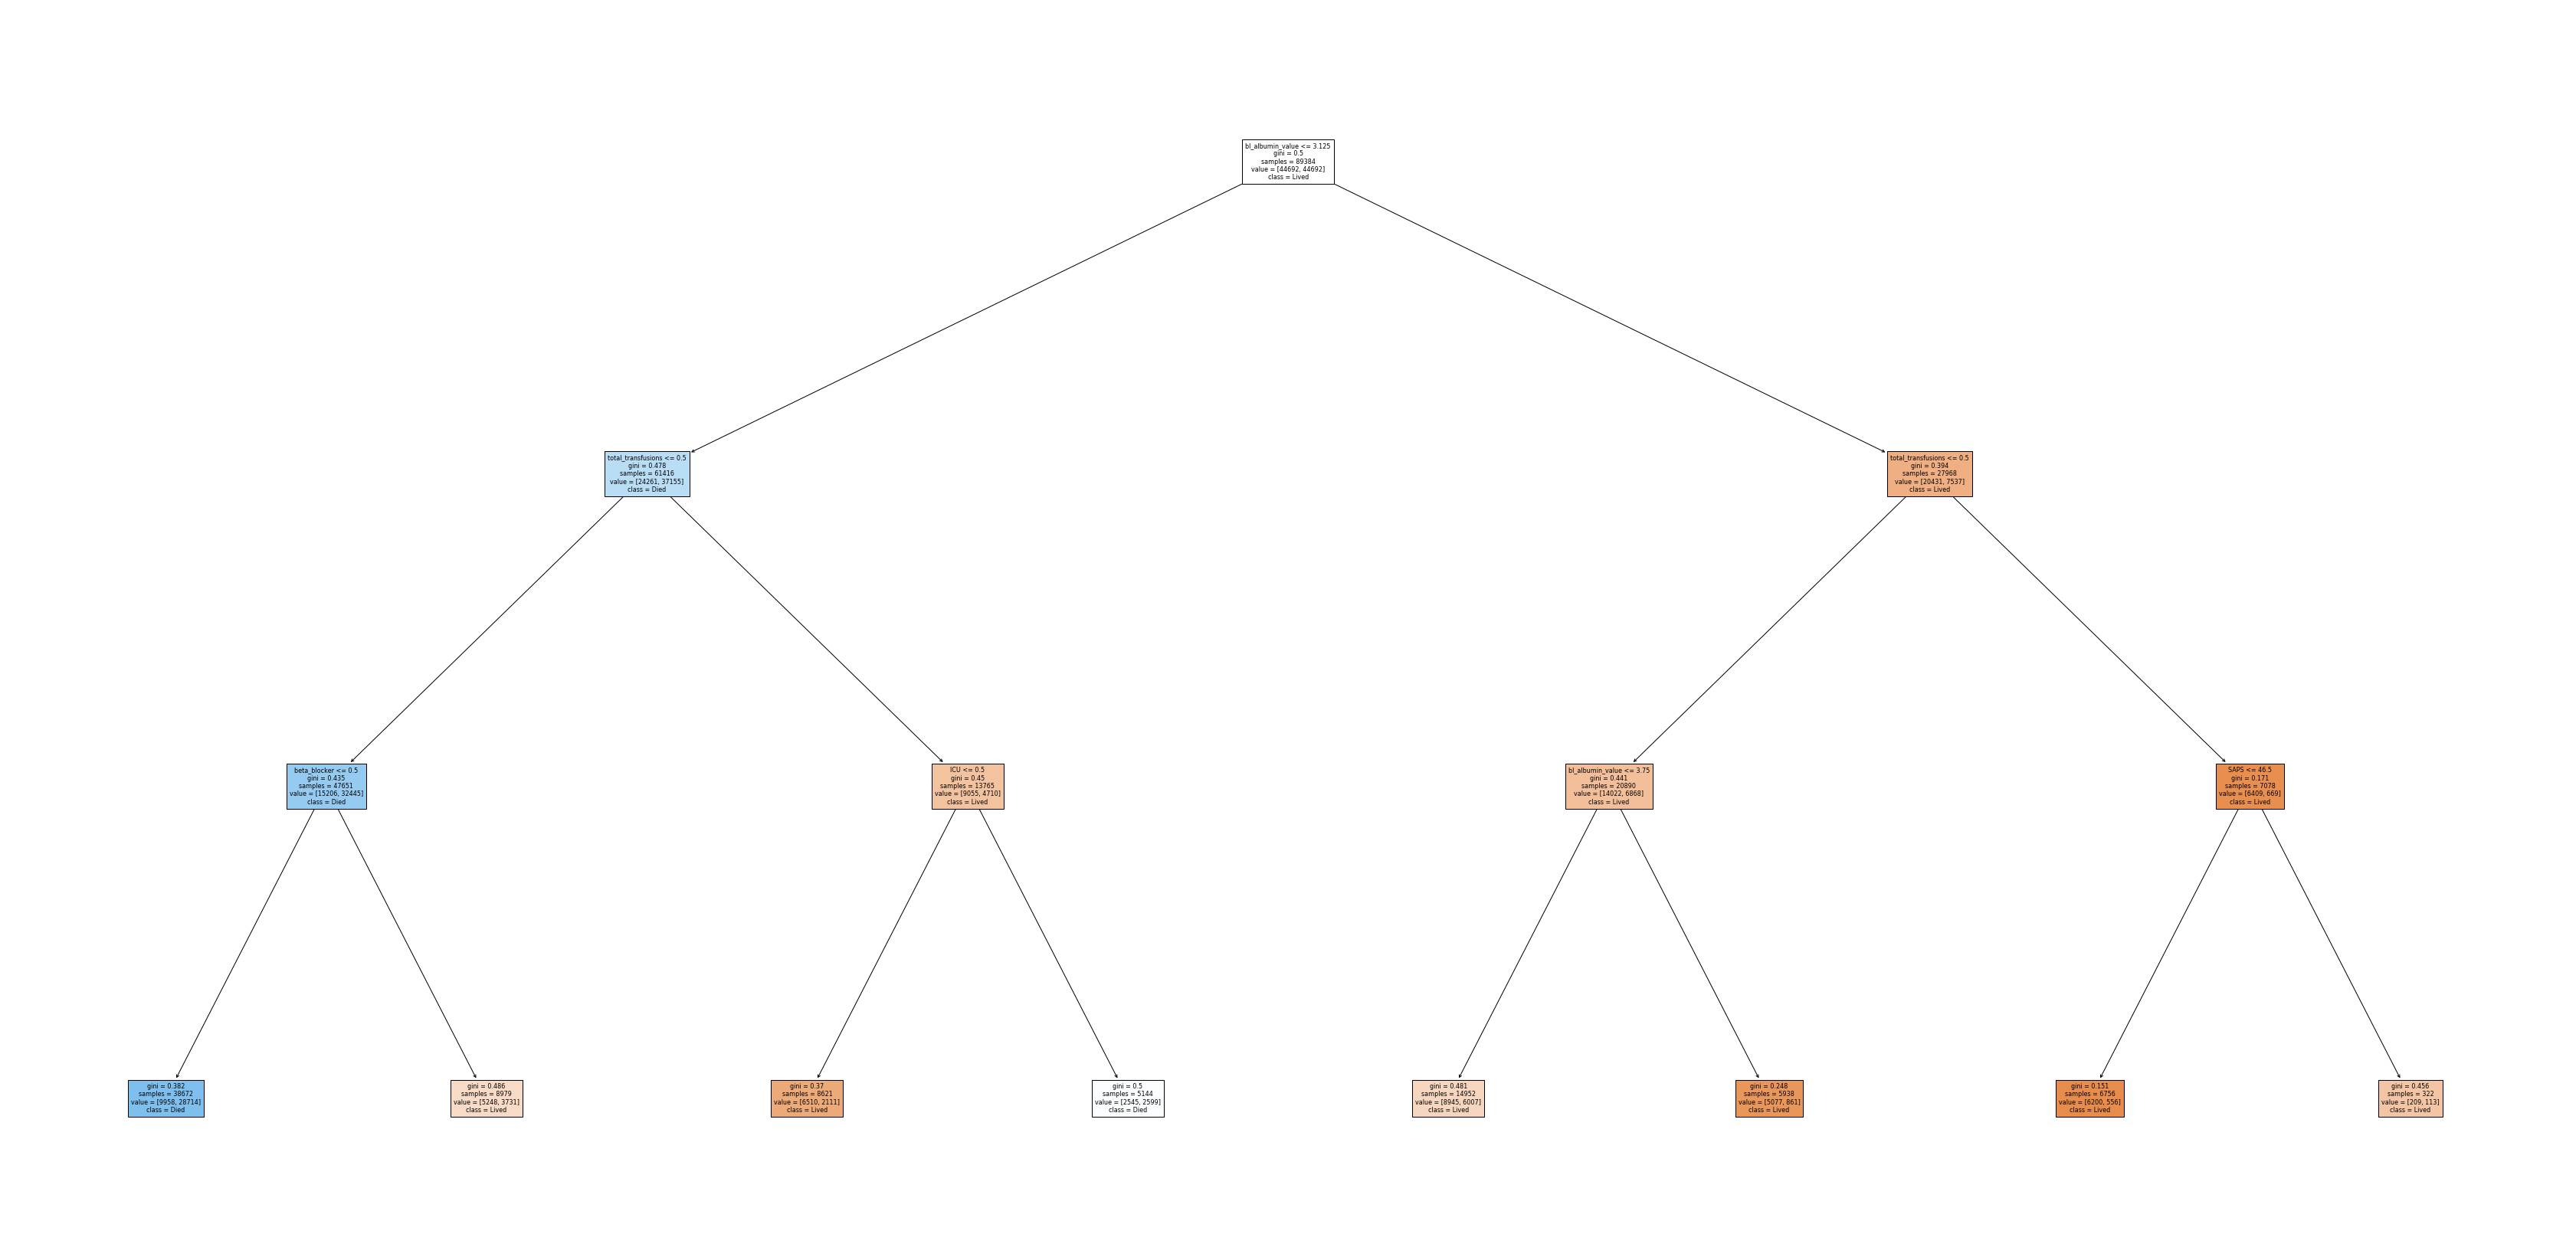

In [41]:
feature_names = X_train.columns.tolist()
class_names = ['Lived', 'Died']

fig = plt.figure(figsize=(60,30))
_ = tree.plot_tree(dt,
                   fontsize=8,
                   feature_names=feature_names,  
                   class_names=class_names,
                   filled=True)

In [42]:
dot_data = tree.export_graphviz(dt, out_file=None, 
                     feature_names=feature_names,  
                     class_names=class_names,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.write_png('30DM_DT_D3_NC.png')

True

## 2: Decision Tree (Max Depth=4)

In [43]:
# instantiate a decision tree model
# max_depth limits depth of tree, helps prevent overfitting training data
dt = tree.DecisionTreeClassifier(max_depth=4)
# fit the model to X and y training sets
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4)

Feature: ICU Score: 0.03933
Feature: mass_transfusion Score: 0.00000
Feature: total_transfusions Score: 0.25932
Feature: anemia_status Score: 0.07310
Feature: CCI Score: 0.05717
Feature: bl_albumin_value Score: 0.41806
Feature: albumin_24hrs Score: 0.00000
Feature: qSOFA Score: 0.00000
Feature: Cirrhosis Score: 0.00000
Feature: beta_blocker Score: 0.14923
Feature: hemorrhagic Score: 0.00000
Feature: SAPS Score: 0.00380


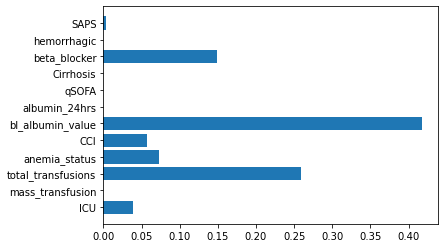

In [44]:
# get importance from decision tree model
importance = dt.feature_importances_
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()

In [45]:
# generate model prediction data for train and test sets
y_hat_train = dt.predict(X_train)
y_hat_test = dt.predict(X_test)

In [46]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[30617 14075]
 [10543 34149]]


In [47]:
# model metrics for train set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

           0       0.74      0.69      0.71     44692
           1       0.71      0.76      0.74     44692

    accuracy                           0.72     89384
   macro avg       0.73      0.72      0.72     89384
weighted avg       0.73      0.72      0.72     89384



In [48]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[7729 3451]
 [ 543  499]]


In [49]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.93      0.69      0.79     11180
           1       0.13      0.48      0.20      1042

    accuracy                           0.67     12222
   macro avg       0.53      0.59      0.50     12222
weighted avg       0.87      0.67      0.74     12222



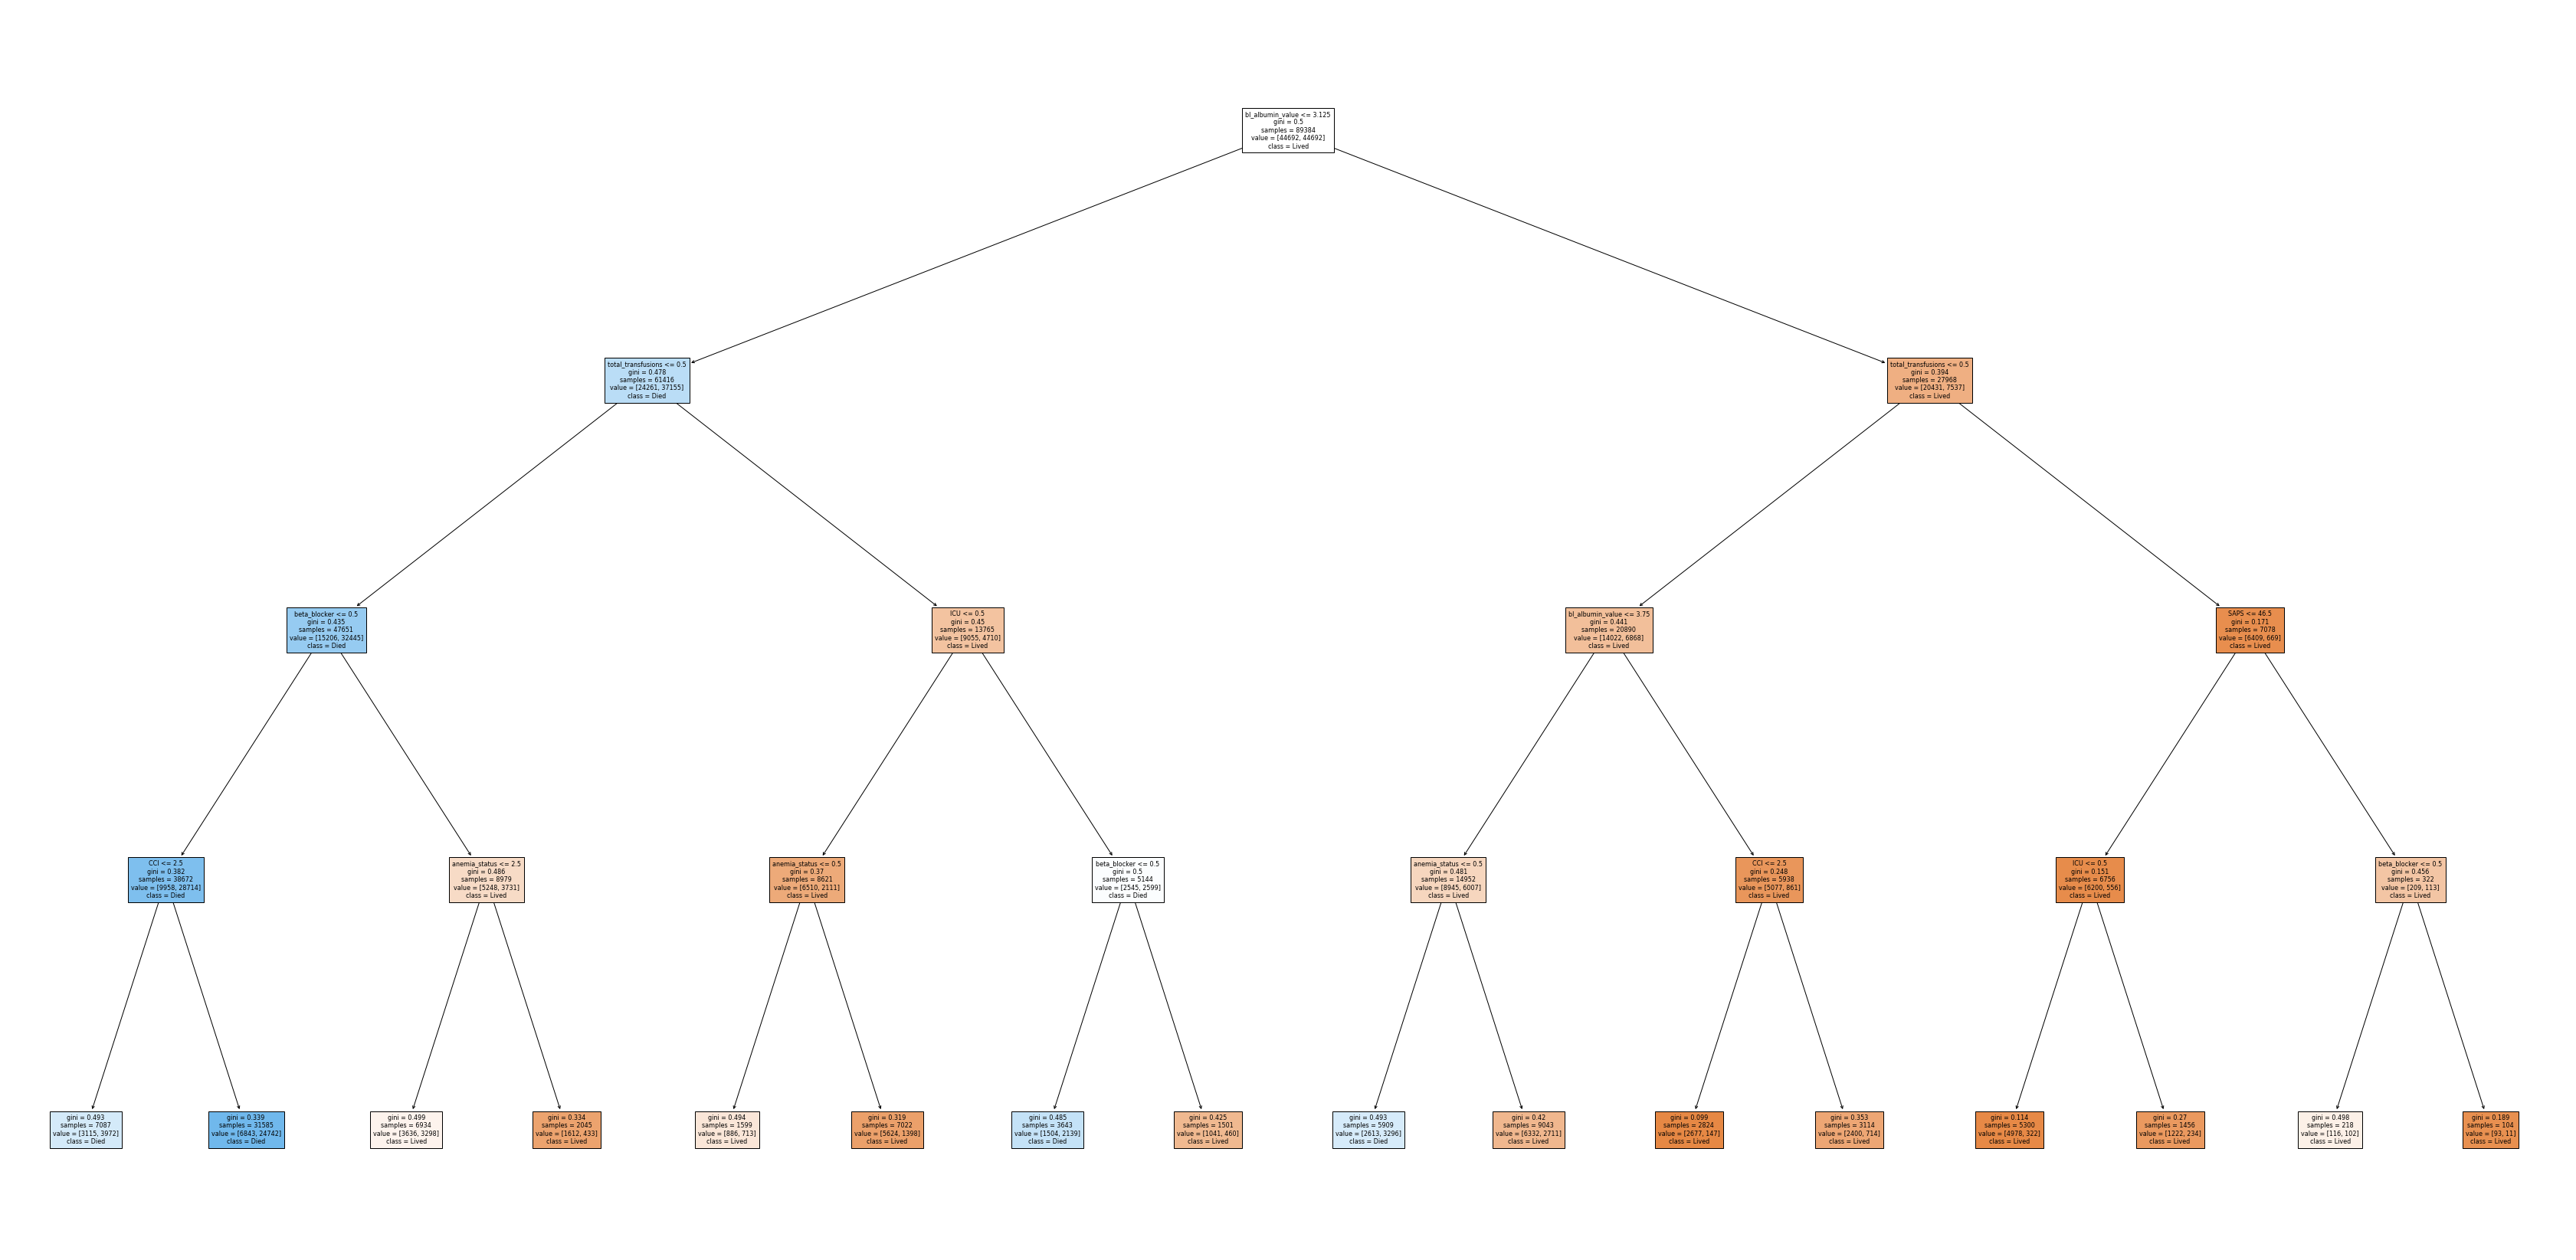

In [50]:
feature_names = X_train.columns.tolist()
class_names = ['Lived', 'Died']

fig = plt.figure(figsize=(60,30))
_ = tree.plot_tree(dt,
                   fontsize=8,
                   feature_names=feature_names,  
                   class_names=class_names,
                   filled=True)

In [51]:
dot_data = tree.export_graphviz(dt, out_file=None, 
                     feature_names=feature_names,  
                     class_names=class_names,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.write_png('30DM_DT_D4_NC.png')

True

## 3: Decision Tree 

In [52]:
# instantiate a decision tree model
# max_depth limits depth of tree, helps prevent overfitting training data
# max_depth 5
dt = tree.DecisionTreeClassifier(max_depth=5)
# fit the model to X and y training sets
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5)

Feature: ICU Score: 0.06486
Feature: mass_transfusion Score: 0.00000
Feature: total_transfusions Score: 0.22741
Feature: anemia_status Score: 0.08817
Feature: CCI Score: 0.07675
Feature: bl_albumin_value Score: 0.37605
Feature: albumin_24hrs Score: 0.00000
Feature: qSOFA Score: 0.02133
Feature: Cirrhosis Score: 0.00000
Feature: beta_blocker Score: 0.13009
Feature: hemorrhagic Score: 0.00000
Feature: SAPS Score: 0.01535


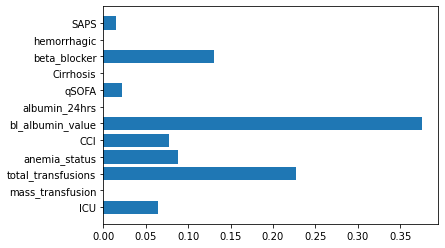

In [53]:
# get importance from decision tree model
importance = dt.feature_importances_
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()

In [54]:
# generate model prediction data for train and test sets
y_hat_train = dt.predict(X_train)
y_hat_test = dt.predict(X_test)

In [55]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[34070 10622]
 [11941 32751]]


In [56]:
# model metrics for train set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

           0       0.74      0.76      0.75     44692
           1       0.76      0.73      0.74     44692

    accuracy                           0.75     89384
   macro avg       0.75      0.75      0.75     89384
weighted avg       0.75      0.75      0.75     89384



In [57]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[8472 2708]
 [ 552  490]]


In [58]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.94      0.76      0.84     11180
           1       0.15      0.47      0.23      1042

    accuracy                           0.73     12222
   macro avg       0.55      0.61      0.53     12222
weighted avg       0.87      0.73      0.79     12222



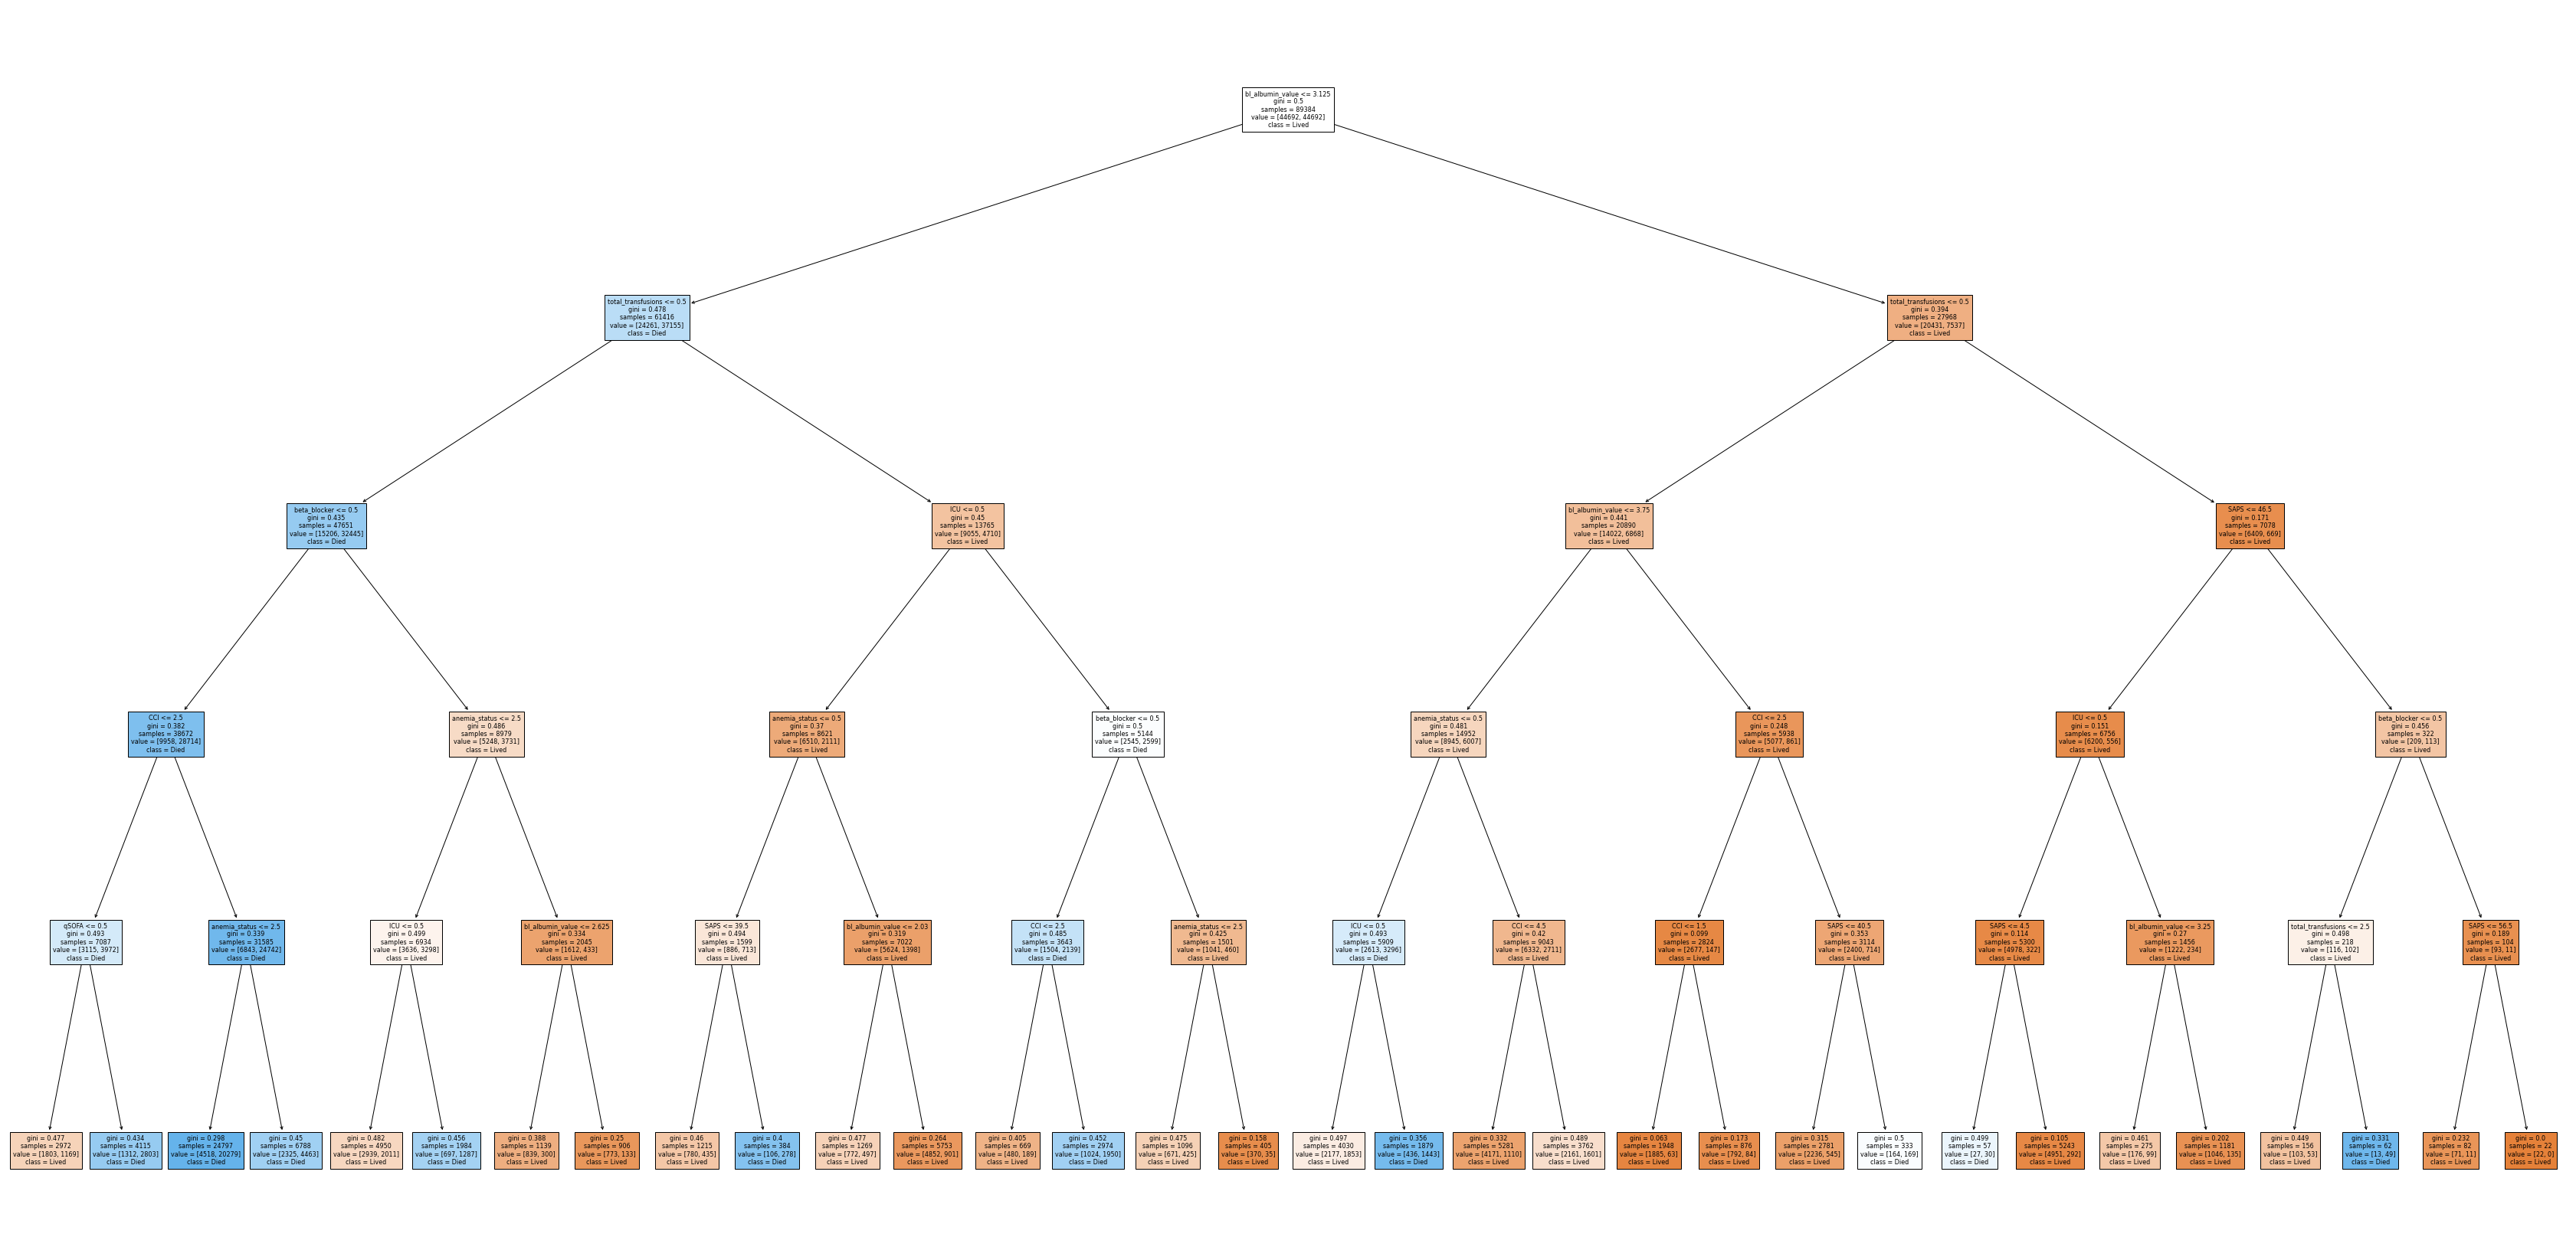

In [59]:
feature_names = X_train.columns.tolist()
class_names = ['Lived', 'Died']

fig = plt.figure(figsize=(60,30))
_ = tree.plot_tree(dt,
                   fontsize=8,
                   feature_names=feature_names,  
                   class_names=class_names,
                   filled=True)

In [60]:
dot_data = tree.export_graphviz(dt, out_file=None, 
                     feature_names=feature_names,  
                     class_names=class_names,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.write_png('30DM_DT_D5_NC.png')

True

## 4: Decision Tree 

In [61]:
# instantiate a decision tree model
# max_depth limits depth of tree, helps prevent overfitting training data
# max_depth 5
dt = tree.DecisionTreeClassifier(max_depth=6, min_samples_leaf=100)
# fit the model to X and y training sets
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=100)

Feature: ICU Score: 0.06809
Feature: mass_transfusion Score: 0.00125
Feature: total_transfusions Score: 0.20310
Feature: anemia_status Score: 0.10912
Feature: CCI Score: 0.07996
Feature: bl_albumin_value Score: 0.36182
Feature: albumin_24hrs Score: 0.00000
Feature: qSOFA Score: 0.03041
Feature: Cirrhosis Score: 0.00026
Feature: beta_blocker Score: 0.11978
Feature: hemorrhagic Score: 0.00000
Feature: SAPS Score: 0.02621


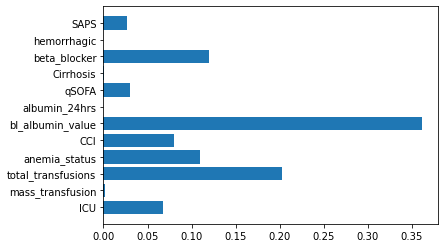

In [62]:
# get importance from decision tree model
importance = dt.feature_importances_
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()

In [63]:
# generate model prediction data for train and test sets
y_hat_train = dt.predict(X_train)
y_hat_test = dt.predict(X_test)

In [64]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[33119 11573]
 [10073 34619]]


In [65]:
# model metrics for train set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

           0       0.77      0.74      0.75     44692
           1       0.75      0.77      0.76     44692

    accuracy                           0.76     89384
   macro avg       0.76      0.76      0.76     89384
weighted avg       0.76      0.76      0.76     89384



In [66]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[8255 2925]
 [ 540  502]]


In [67]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.94      0.74      0.83     11180
           1       0.15      0.48      0.22      1042

    accuracy                           0.72     12222
   macro avg       0.54      0.61      0.53     12222
weighted avg       0.87      0.72      0.78     12222



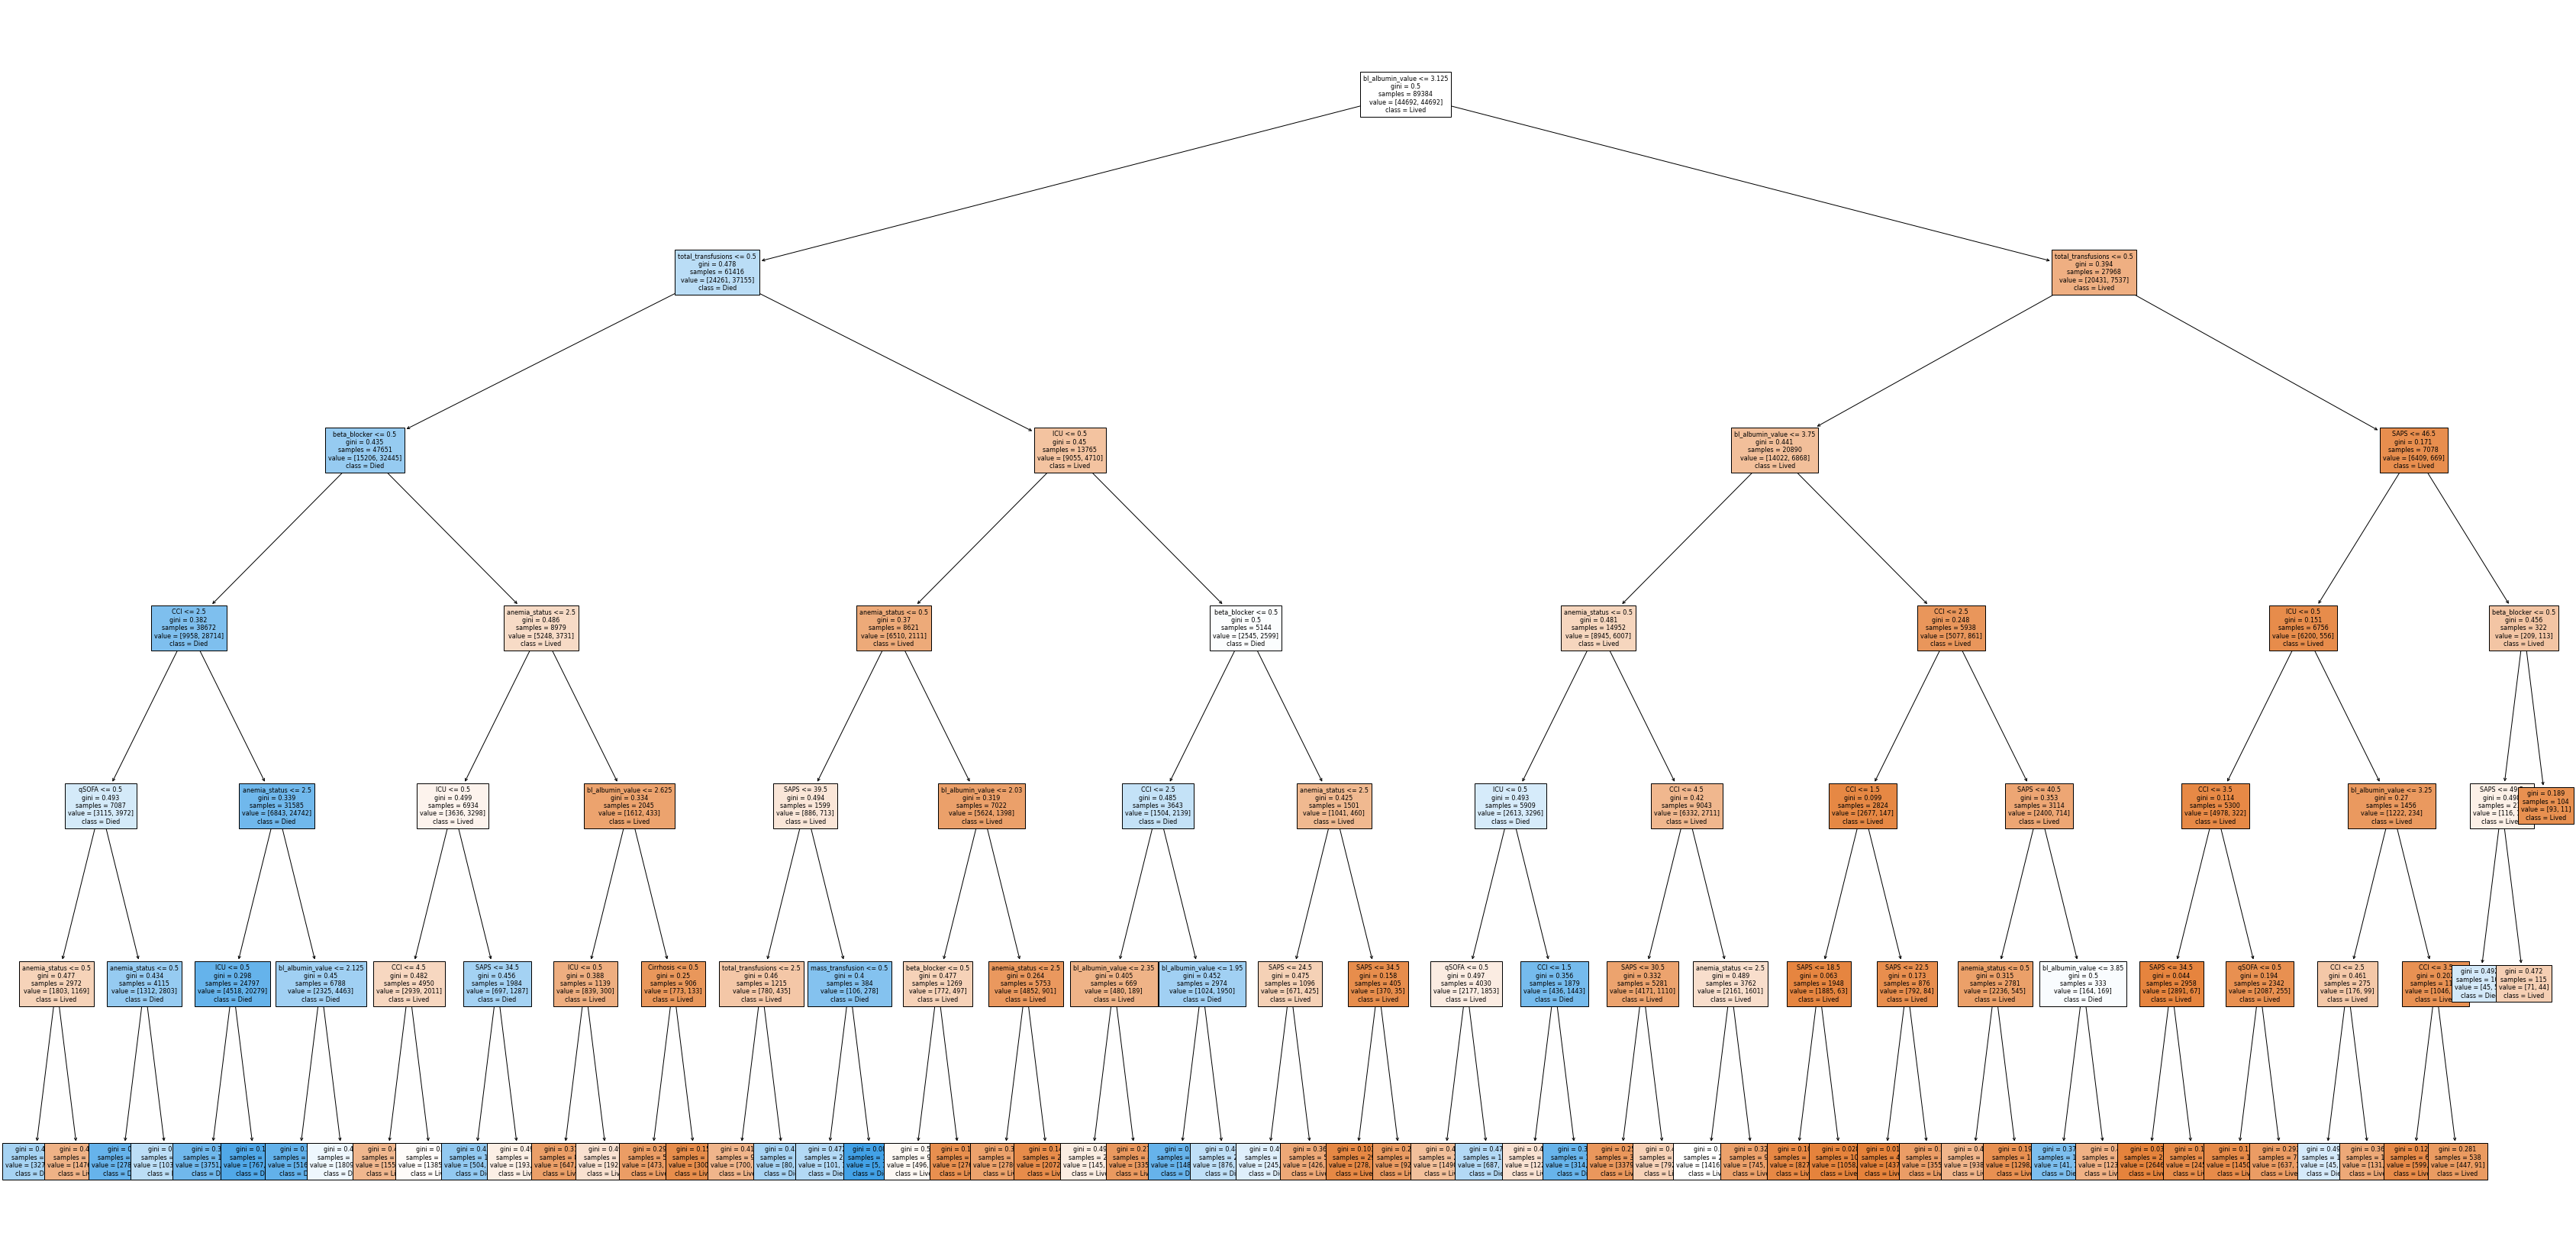

In [68]:
feature_names = X_train.columns.tolist()
class_names = ['Lived', 'Died']

fig = plt.figure(figsize=(60,30))
_ = tree.plot_tree(dt,
                   fontsize=8,
                   feature_names=feature_names,  
                   class_names=class_names,
                   filled=True)

In [69]:
dot_data = tree.export_graphviz(dt, out_file=None, 
                     feature_names=feature_names,  
                     class_names=class_names,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.write_png('30DM_DT_D6_NC.png')

True

## 5: Decision Tree 

In [70]:
# instantiate a decision tree model
# max_depth limits depth of tree, helps prevent overfitting training data
# max_depth 5
dt = tree.DecisionTreeClassifier(max_depth=7, min_samples_leaf=100)
# fit the model to X and y training sets
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=7, min_samples_leaf=100)

Feature: ICU Score: 0.06776
Feature: mass_transfusion Score: 0.00340
Feature: total_transfusions Score: 0.18365
Feature: anemia_status Score: 0.10374
Feature: CCI Score: 0.08221
Feature: bl_albumin_value Score: 0.35478
Feature: albumin_24hrs Score: 0.00228
Feature: qSOFA Score: 0.03093
Feature: Cirrhosis Score: 0.00023
Feature: beta_blocker Score: 0.11067
Feature: hemorrhagic Score: 0.00301
Feature: SAPS Score: 0.05733


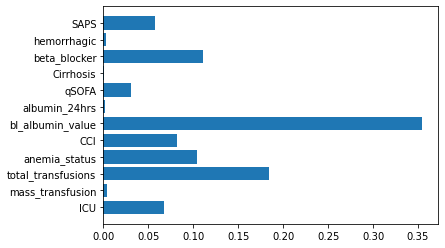

In [71]:
# get importance from decision tree model
importance = dt.feature_importances_
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()

In [72]:
# generate model prediction data for train and test sets
y_hat_train = dt.predict(X_train)
y_hat_test = dt.predict(X_test)

In [73]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[33906 10786]
 [ 8930 35762]]


In [74]:
# model metrics for train set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

           0       0.79      0.76      0.77     44692
           1       0.77      0.80      0.78     44692

    accuracy                           0.78     89384
   macro avg       0.78      0.78      0.78     89384
weighted avg       0.78      0.78      0.78     89384



In [75]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[8465 2715]
 [ 520  522]]


In [76]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.94      0.76      0.84     11180
           1       0.16      0.50      0.24      1042

    accuracy                           0.74     12222
   macro avg       0.55      0.63      0.54     12222
weighted avg       0.88      0.74      0.79     12222



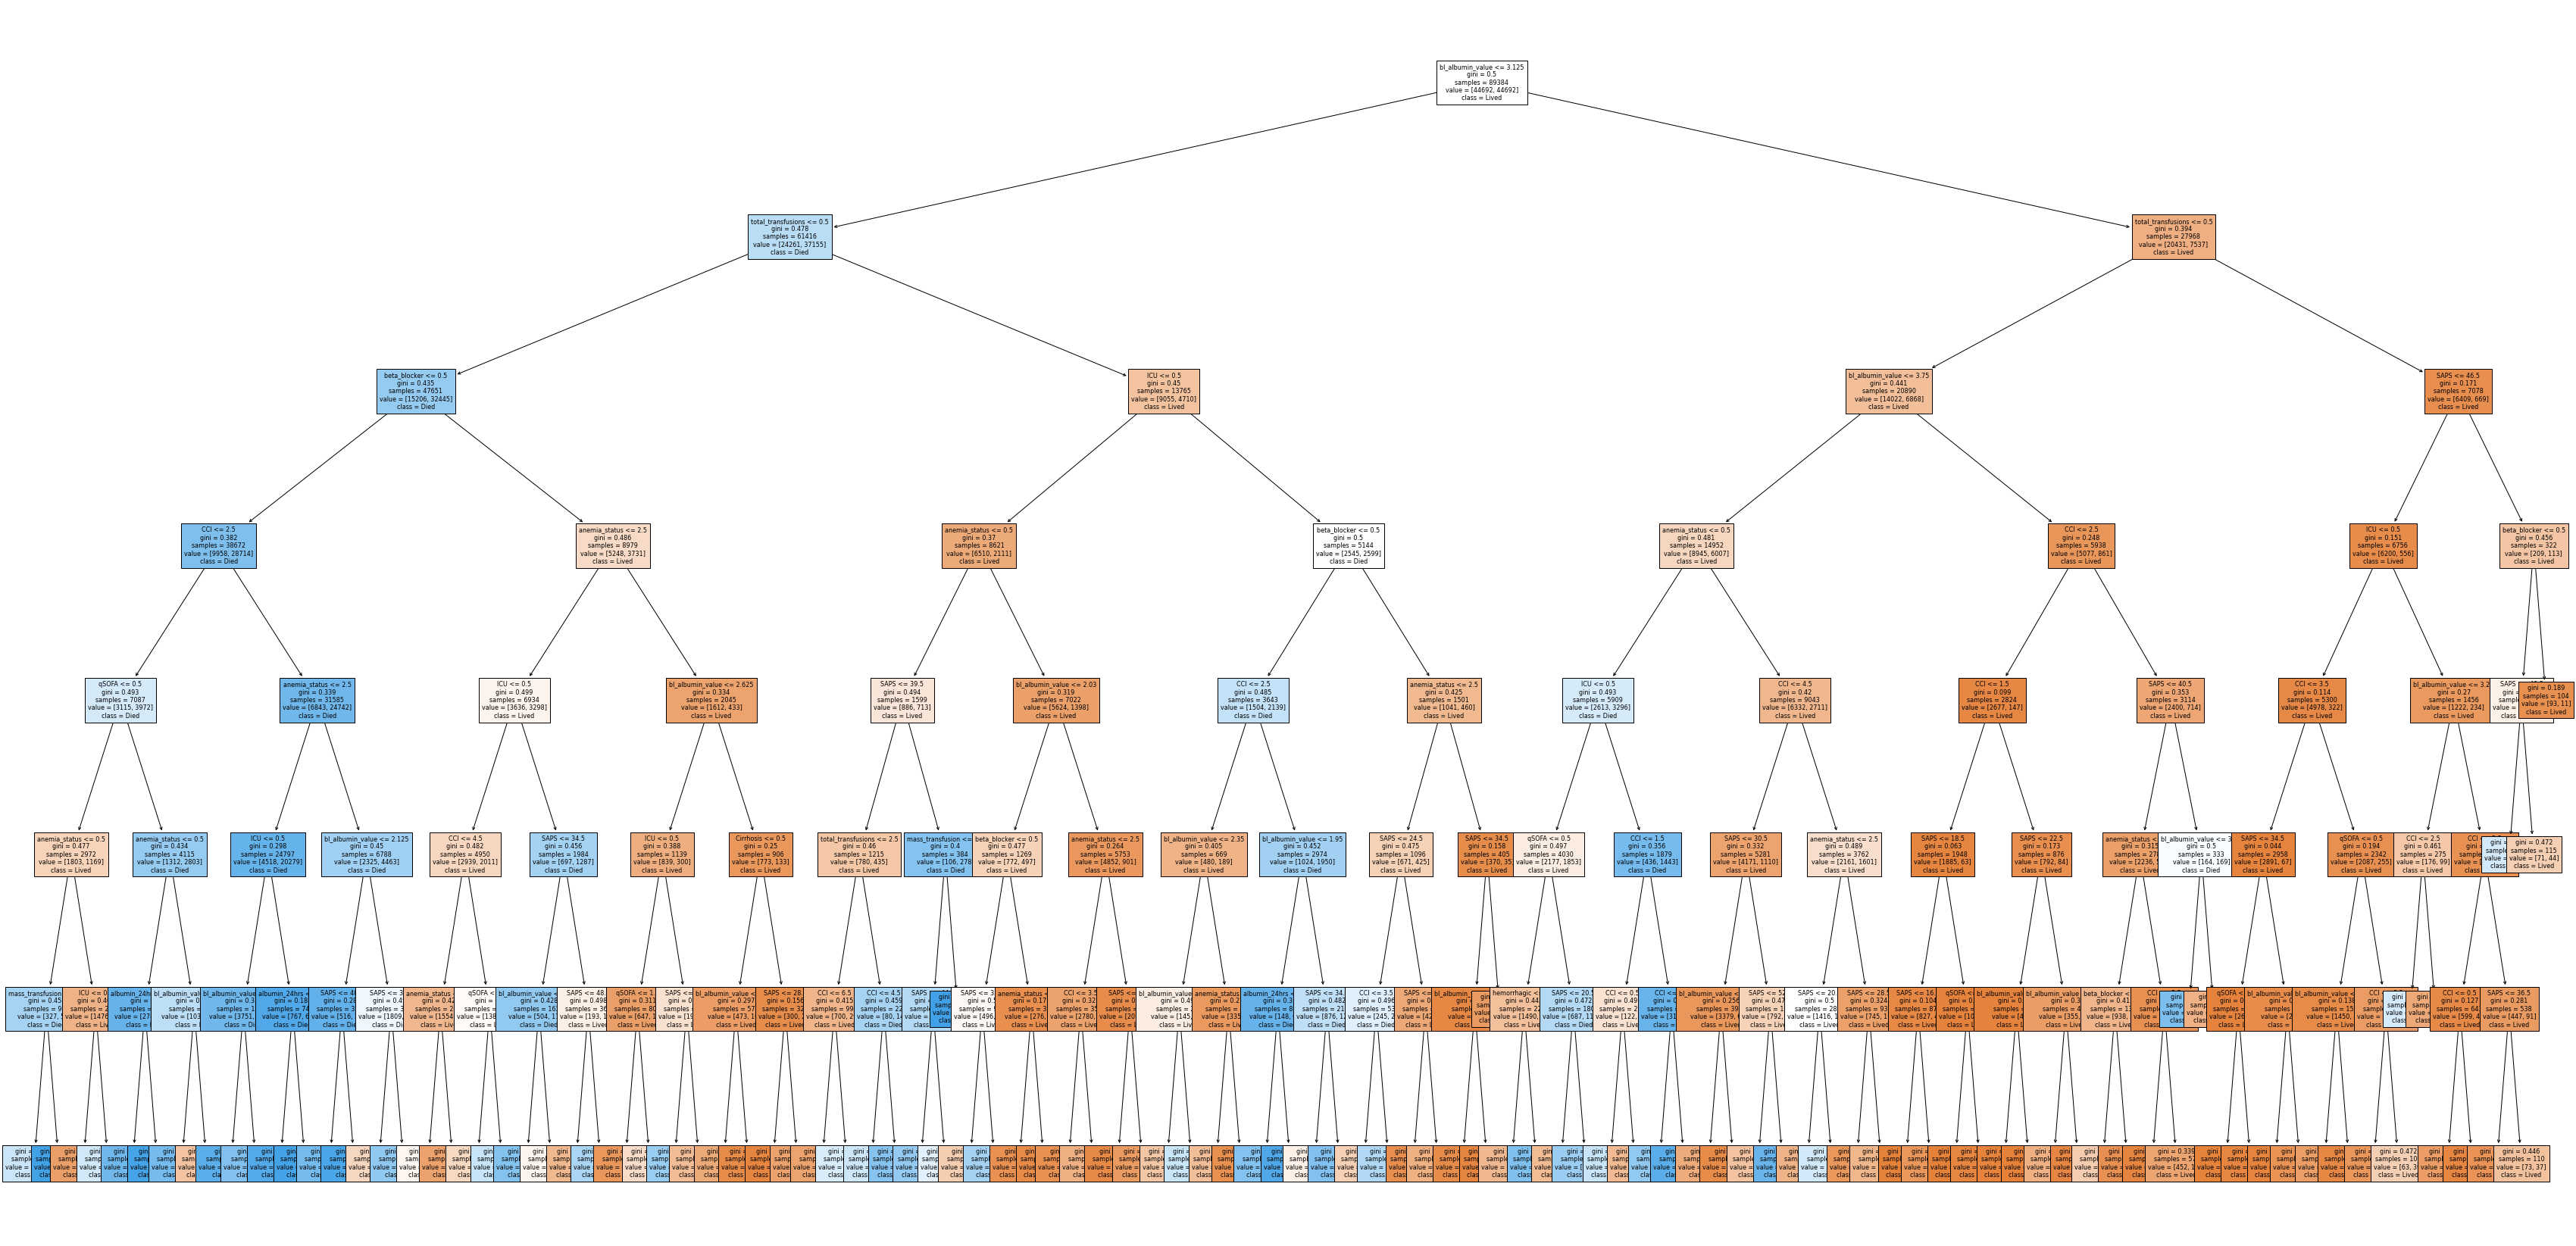

In [77]:
feature_names = X_train.columns.tolist()
class_names = ['Lived', 'Died']

fig = plt.figure(figsize=(60,30))
_ = tree.plot_tree(dt,
                   fontsize=8,
                   feature_names=feature_names,  
                   class_names=class_names,
                   filled=True)

In [78]:
dot_data = tree.export_graphviz(dt, out_file=None, 
                     feature_names=feature_names,  
                     class_names=class_names,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.write_png('30DM_DT_D7_NC.png')

True

## Random Forest

In [79]:
rf = RandomForestClassifier(max_depth=8, min_samples_leaf=100)
# fit the model to X and y training sets
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, min_samples_leaf=100)

In [80]:
# generate model prediction data for train and test sets
y_hat_train = rf.predict(X_train)
y_hat_test = rf.predict(X_test)

In [81]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[34721  9971]
 [ 8589 36103]]


In [82]:
# model metrics for train set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

           0       0.80      0.78      0.79     44692
           1       0.78      0.81      0.80     44692

    accuracy                           0.79     89384
   macro avg       0.79      0.79      0.79     89384
weighted avg       0.79      0.79      0.79     89384



In [83]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[8600 2580]
 [ 510  532]]


In [84]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.94      0.77      0.85     11180
           1       0.17      0.51      0.26      1042

    accuracy                           0.75     12222
   macro avg       0.56      0.64      0.55     12222
weighted avg       0.88      0.75      0.80     12222



Feature: ICU Score: 0.06460
Feature: mass_transfusion Score: 0.00605
Feature: total_transfusions Score: 0.16716
Feature: anemia_status Score: 0.07228
Feature: CCI Score: 0.09857
Feature: bl_albumin_value Score: 0.25716
Feature: albumin_24hrs Score: 0.02700
Feature: qSOFA Score: 0.08815
Feature: Cirrhosis Score: 0.00512
Feature: beta_blocker Score: 0.12041
Feature: hemorrhagic Score: 0.01374
Feature: SAPS Score: 0.07976


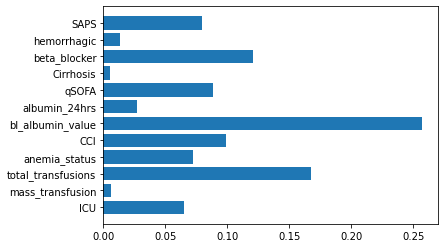

In [85]:
# get importance from decision tree model
importance = rf.feature_importances_
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()